# Graph Neural Network for Multi-Asset Market Modeling — Variant C 📈

This notebook implements a GNN + LSTM model for predicting the next-step direction of Asset A using multi-asset time series, incorporating **learnable attention** over a set of precomputed correlation windows.

### Features
- Candidate correlation windows: **30min, 1h, 2h, 4h**
- **NaN-safe** normalization and correlation calculation.
- **Multi-window attention** (softmax-weighted combination) for dynamic correlation weighting.
- Monitoring attention weights per epoch for **interpretability**.
- Synthetic dataset $T \approx 3000$.

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Research-grade GNN-LSTM pipeline for multi-asset market modeling.
Predicts direction of price for Asset ETH using multi-window attention over correlations.

Structure:
1) Synthetic data generation (3k rows, 5m intervals)
2) Preprocessing, cleaning, winsorization, normalization
3) Rolling correlations with multiple windows (5 windows)
4) Dataset + DataLoader + collate_fn
5) GNN (GCN-style) + LSTM temporal aggregator + classifier
6) Train/Val/Test split 50-20-30
7) Training loop with accuracy, loss tracking
8) Monitoring attention + avg adjacency
9) Visualization for train and for test
"""

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import pandas as pd
from pathlib import Path

In [2]:

# ============================================================
# 1. Load data
# ============================================================


def load_asset(asset):
    freq = '5min'
    DATA_DIR = Path('../dataset')
    path = DATA_DIR / f"{asset}_{freq}.csv"

    df = pd.read_csv(path)
    df['timestamp'] = pd.to_datetime(df["system_time"])
    df['timestamp'] = df['timestamp'].dt.round('min')
    df = df.sort_values('timestamp').set_index('timestamp')
    return df[['midpoint','bids_notional_0', 'asks_notional_0', 'spread', 'buys', 'sells']]  
    
df_ADA = load_asset("ADA").rename(columns={'midpoint': 'ADA', 'buys': 'buys_ADA', 'sells': 'sells_ADA', 'bids_notional_0': 'bids_vol_ADA', 'asks_notional_0': 'asks_vol_ADA', 'spread': 'spread_ADA', })
df_BTC = load_asset("BTC").rename(columns={'midpoint': 'BTC', 'buys': 'buys_BTC', 'sells': 'sells_BTC', 'bids_notional_0': 'bids_vol_BTC', 'asks_notional_0': 'asks_vol_BTC', 'spread': 'spread_BTC', })
df_ETH = load_asset("ETH").rename(columns={'midpoint': 'ETH', 'buys': 'buys_ETH', 'sells': 'sells_ETH', 'bids_notional_0': 'bids_vol_ETH', 'asks_notional_0': 'asks_vol_ETH', 'spread': 'spread_ETH', })
df = df_ADA.join(df_BTC).join(df_ETH)

df.reset_index(inplace=True)

T = len(df)

# log returns & target
df["lr_ADA"] = np.log(df["ADA"]).diff().fillna(0)
df["lr_BTC"] = np.log(df["BTC"]).diff().fillna(0)
df["lr_ETH"] = np.log(df["ETH"]).diff().fillna(0)
df["target"] = (df["ETH"].shift(-1) > df["ETH"]).astype(int) #next-step direction of Asset ETH --- 50%
#df["target"] = (df["lr_ETH"].shift(-6).abs() > 0.003).astype(int)  # significant move in next 30min --- 70%-80%
#df["target"] = ((df["lr_ETH"].shift(-6) > 0) & (df["lr_ETH"].shift(-6).abs() > 0.001)).astype(int)  # direction of significant move in next 30min --- 60%-70%
#df["target"] = (df["ETH"].shift(-6) > df["ETH"]).astype(int)    # direction in next 30min --- 50%

#df["fwd_lr_12"] = df["lr_ETH"].rolling(12).sum().shift(-12)
#df["target"] = (df["fwd_lr_12"] > 0).astype(int) # cumulative log return of 1h move --- 50%-54%

#df["target"] = (((df["lr_ETH"].shift(-6) > 0)-0.5)*2 * (df["lr_ETH"].shift(-6).abs() > 0.002)).astype(int)+1  # direction of significant move in next 30min --- 62% against 79% baseline


In [3]:
COLUMNS = ["ADA",
            "buys_ADA", 
            "sells_ADA",
            "bids_vol_ADA",
            "asks_vol_ADA",
            "spread_ADA", 
            "lr_ADA", 
            # ---
            "BTC",
            "buys_BTC", 
            "sells_BTC",
            "bids_vol_BTC",
            "asks_vol_BTC",
            "spread_BTC",
            "lr_BTC",
            # ---
            "ETH",
            "buys_ETH", 
            "sells_ETH",
            "bids_vol_ETH",
            "asks_vol_ETH",
            "spread_ETH",
            "lr_ETH"]


df.target.value_counts(normalize=True)


target
1    0.509356
0    0.490644
Name: proportion, dtype: float64

In [4]:

# ============================================================
# 2. Full cleaning pipeline
# ============================================================

for col in ["buys_ADA", "buys_BTC", "buys_ETH",
            "sells_ADA", "sells_BTC", "sells_ETH",
            "bids_vol_ADA", "bids_vol_BTC", "bids_vol_ETH",
            "asks_vol_ADA", "asks_vol_BTC", "asks_vol_ETH"]:
    df[col] = df[col].clip(lower=1e-6)

def winsorize(series, q=0.995):
    low = series.quantile(1-q)
    high = series.quantile(q)
    return series.clip(lower=low, upper=high)

for col in ["buys_ADA", "buys_BTC", "buys_ETH",
            "sells_ADA", "sells_BTC", "sells_ETH",
            "bids_vol_ADA", "bids_vol_BTC", "bids_vol_ETH",
            "asks_vol_ADA", "asks_vol_BTC", "asks_vol_ETH"]:
    df[col] = winsorize(df[col])

#df.replace([np.inf, -np.inf], np.nan, inplace=True)
#df.ffill(inplace=True)
#df.bfill(inplace=True)

for col in ["ADA", "BTC", "ETH"]:
    df[col] = df[col].clip(lower=1e-8)

for col in ["lr_ADA", "lr_BTC", "lr_ETH"]:
    df[col] = df[col].clip(lower=-0.2, upper=0.2)

print("\nSanitized Data Summary:\n", df.describe())



Sanitized Data Summary:
                ADA  bids_vol_ADA   asks_vol_ADA   spread_ADA      buys_ADA  \
count  3367.000000   3367.000000    3367.000000  3367.000000  3.367000e+03   
mean      1.315086   6653.414656    7457.980906     0.000672  2.213041e+05   
std       0.102222  10142.149344   17320.947592     0.000668  1.976577e+05   
min       1.136350      1.220000       6.063400     0.000100  2.054712e+04   
25%       1.214750   2026.534973    1165.170044     0.000400  9.247319e+04   
50%       1.299500   3189.639893    2870.780029     0.000600  1.628892e+05   
75%       1.415900   5507.334961    6787.079834     0.000800  2.770929e+05   
max       1.557050  77046.272500  186063.859688     0.015300  1.291391e+06   

          sells_ADA           BTC   bids_vol_BTC   asks_vol_BTC   spread_BTC  \
count  3.367000e+03   3365.000000    3365.000000    3365.000000  3365.000000   
mean   1.810783e+05  59973.912582   74033.060271   75248.047593     1.245058   
std    2.047577e+05   2488.5558

In [5]:

# ============================================================
# 3. Multi-window correlations
# ============================================================

candidate_windows = [6, 12, 24, 48, 96]   # 30m, 1h, 2h, 4h, 8h
n_w = len(candidate_windows)

edges = [("ADA","BTC"), ("ADA","ETH"), ("ETH","BTC")]
n_edges = len(edges)

corr_array = np.zeros((T, n_edges, n_w), dtype=np.float32)

for wi, w in enumerate(candidate_windows):
    r_ADA_BTC = df["lr_ADA"].rolling(w, min_periods=1).corr(df["lr_BTC"])
    r_ADA_ETH = df["lr_ADA"].rolling(w, min_periods=1).corr(df["lr_ETH"])
    r_ETH_BTC = df["lr_ETH"].rolling(w, min_periods=1).corr(df["lr_BTC"])

    corr_array[:,0,wi] = np.nan_to_num(r_ADA_BTC)
    corr_array[:,1,wi] = np.nan_to_num(r_ADA_ETH)
    corr_array[:,2,wi] = np.nan_to_num(r_ETH_BTC)

print("corr_array shape:", corr_array.shape)


corr_array shape: (3367, 3, 5)


In [6]:
df.dtypes

timestamp       datetime64[ns, UTC]
ADA                         float64
bids_vol_ADA                float64
asks_vol_ADA                float64
spread_ADA                  float64
buys_ADA                    float64
sells_ADA                   float64
BTC                         float64
bids_vol_BTC                float64
asks_vol_BTC                float64
spread_BTC                  float64
buys_BTC                    float64
sells_BTC                   float64
ETH                         float64
bids_vol_ETH                float64
asks_vol_ETH                float64
spread_ETH                  float64
buys_ETH                    float64
sells_ETH                   float64
lr_ADA                      float64
lr_BTC                      float64
lr_ETH                      float64
target                        int64
dtype: object

## Step 0

In [7]:
# ЛОГИЧЕСКИЙ БЛОК: imports + reproducibility + config
# ИСПОЛНЕНИЕ БЛОКА:

import os, math, random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix

import matplotlib.pyplot as plt

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE:", DEVICE)

CFG = {
    "lookback": 48,          # 4 часа при 5m
    "horizon": 1,            # твой target уже next-step (shift -1)
    "batch_size": 64,
    "epochs": 30,
    "lr": 2e-4,
    "weight_decay": 1e-3,
    "grad_clip": 1.0,
    "dropout": 0.15,
    "hidden": 64,            # размер node-эмбеддинга
    "gnn_layers": 2,
    "lstm_hidden": 64,
    "lstm_layers": 1,
    "label_smoothing": 0.02,
    "max_abs_feat": 10.0,    # пост-клип после скейлинга
    "use_amp": True,         # mixed precision если cuda
}

ASSETS = ["ADA", "BTC", "ETH"]
ASSET2IDX = {a:i for i,a in enumerate(ASSETS)}
TARGET_ASSET = "ETH"
TARGET_NODE = ASSET2IDX[TARGET_ASSET]

# фиксированный список ребер как у тебя (E=3)
EDGES = [("ADA","BTC"), ("ADA","ETH"), ("ETH","BTC")]
EDGE_INDEX = torch.tensor([[ASSET2IDX[s], ASSET2IDX[t]] for (s,t) in EDGES], dtype=torch.long)  # [E,2]
print("EDGE_INDEX:", EDGE_INDEX.tolist())


DEVICE: cpu
EDGE_INDEX: [[0, 1], [0, 2], [2, 1]]


## 1. Feature engineering: node-features и edge-features

In [8]:
# ЛОГИЧЕСКИЙ БЛОК: optional targets (vol-adjusted, 3-class). Choose one and rebuild y/datasets.
# ИСПОЛНЕНИЕ БЛОКА:

def make_target_vol_adjusted(df, horizon=6, vol_window=96, k=0.5):
    """
    horizon=6 -> 30 минут
    k=0.5 означает: учитываем направление только если |fwd_return| > k * rolling_vol
    Возвращает бинарный target (0/1) и mask "trade" (1 если движение значимое)
    """
    lr = df["lr_ETH"].astype(float)
    fwd = lr.shift(-horizon)
    vol = lr.rolling(vol_window, min_periods=10).std()
    thr = k * vol

    trade = (fwd.abs() > thr).astype(int)
    target = (fwd > 0).astype(int)  # направление
    # можно занулить target там где trade=0, но тогда нужно учить masked loss или 3-класс
    return target.fillna(0).astype(int), trade.fillna(0).astype(int)

def make_target_3class(df, horizon=6, flat_thr=0.001):
    """
    0=down, 1=flat, 2=up
    """
    fwd = df["lr_ETH"].shift(-horizon)
    y3 = np.where(fwd > flat_thr, 2, np.where(fwd < -flat_thr, 0, 1))
    return pd.Series(y3).fillna(1).astype(int)

df["target"], df["trade_mask"] = make_target_vol_adjusted(df, horizon=6, vol_window=96, k=0.90)
#df["target"] = df["target"]*df["trade_mask"]
#df["target"] = make_target_3class(df, horizon=6, flat_thr=0.002)
#y = df["target"].values.astype(np.int64)
# ... затем пересобрать sample_t/datasets (блоки 2-3)
print("Optional targets are ready (see functions).")
print("Class distribution:\n", df["target"].value_counts(normalize=True))


Optional targets are ready (see functions).
Class distribution:
 target
1    0.508465
0    0.491535
Name: proportion, dtype: float64


In [9]:
# ЛОГИЧЕСКИЙ БЛОК: build node features (T,N,F) + edge features (T,E,W) + target
# ИСПОЛНЕНИЕ БЛОКА:

assert "target" in df.columns, "df должен содержать 'target'"
assert isinstance(corr_array, np.ndarray) and corr_array.ndim == 3, "corr_array должен быть (T,E,W)"
T = len(df)
E = corr_array.shape[1]
W = corr_array.shape[2]
assert E == len(EDGES), "corr_array E должно совпадать с EDGES"
print("T,E,W:", T, E, W)

EPS = 1e-6

def safe_log1p(x):
    return np.log1p(np.maximum(x, 0.0))

def build_node_tensor(df: pd.DataFrame):
    feats = []
    feat_names = []
    for a in ASSETS:
        # обязательные колонки по твоей схеме
        lr = df[f"lr_{a}"].values.astype(np.float32)
        spread = df[f"spread_{a}"].values.astype(np.float32)

        bids = df[f"bids_vol_{a}"].values.astype(np.float32)
        asks = df[f"asks_vol_{a}"].values.astype(np.float32)
        buys = df[f"buys_{a}"].values.astype(np.float32)
        sells = df[f"sells_{a}"].values.astype(np.float32)

        # устойчивые преобразования
        log_bids = safe_log1p(bids).astype(np.float32)
        log_asks = safe_log1p(asks).astype(np.float32)
        log_buys = safe_log1p(buys).astype(np.float32)
        log_sells = safe_log1p(sells).astype(np.float32)

        ofi = (buys - sells) / (buys + sells + EPS)
        di  = (bids - asks)  / (bids + asks + EPS)
        ofi = ofi.astype(np.float32)
        di  = di.astype(np.float32)

        # (T,F_a)
        Xa = np.stack([lr, spread, log_bids, log_asks, log_buys, log_sells, ofi, di], axis=1)
        feats.append(Xa)
        if not feat_names:
            feat_names = ["lr", "spread", "log_bids", "log_asks", "log_buys", "log_sells", "ofi", "di"]

    # (T,N,F)
    X = np.stack(feats, axis=1).astype(np.float32)
    return X, feat_names

X_node, node_feat_names = build_node_tensor(df)  # (T,N,F)
y = df["target"].values.astype(np.int64)         # (T,)

edge_feat = corr_array.astype(np.float32)        # (T,E,W)

print("X_node:", X_node.shape, "edge_feat:", edge_feat.shape, "y:", y.shape)
print("Node features:", node_feat_names)


T,E,W: 3367 3 5
X_node: (3367, 3, 8) edge_feat: (3367, 3, 5) y: (3367,)
Node features: ['lr', 'spread', 'log_bids', 'log_asks', 'log_buys', 'log_sells', 'ofi', 'di']


## 2. Time split 50/20/30, train-only scaling (leakage-safe)

In [10]:
# ЛОГИЧЕСКИЙ БЛОК: build samples indices + train/val/test split + robust scaling (train-only)
# ИСПОЛНЕНИЕ БЛОКА:

L = CFG["lookback"]
H = CFG["horizon"]

# usable end-times t: need [t-L+1 .. t] and label y[t], plus target already shift(-1) inside df
# чтобы избежать края: т.к. target использует shift(-1), последняя строка "условно" шумная -> исключим хвост H
t_min = L - 1
t_max = T - H - 1
sample_t = np.arange(t_min, t_max + 1)  # end index per sample
n_samples = len(sample_t)
print("n_samples:", n_samples, "t range:", sample_t[0], sample_t[-1])

train_end = int(0.50 * n_samples)
val_end   = int(0.70 * n_samples)

idx_train = np.arange(0, train_end)
idx_val   = np.arange(train_end, val_end)
idx_test  = np.arange(val_end, n_samples)

print("split sizes:", len(idx_train), len(idx_val), len(idx_test))

# === Fit scalers on TRAIN TIMES ONLY ===
# Берем времена до последнего train sample end-time
last_train_t = sample_t[idx_train[-1]]
train_time_mask = np.arange(0, last_train_t + 1)

X_train_time = X_node[train_time_mask]  # (T_train_time, N, F)
Ttr, N, Fdim = X_train_time.shape

scaler = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(5.0, 95.0))
scaler.fit(X_train_time.reshape(-1, Fdim))

X_node_scaled = scaler.transform(X_node.reshape(-1, Fdim)).reshape(T, N, Fdim).astype(np.float32)
X_node_scaled = np.clip(X_node_scaled, -CFG["max_abs_feat"], CFG["max_abs_feat"]).astype(np.float32)
X_node_scaled = np.nan_to_num(X_node_scaled, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)

# edge features (корреляции) обычно в [-1,1], просто чистим
edge_feat_clean = np.nan_to_num(edge_feat, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)

print("Scaled node stats:", np.min(X_node_scaled), np.max(X_node_scaled))
print("Edge stats:", np.min(edge_feat_clean), np.max(edge_feat_clean))


n_samples: 3319 t range: 47 3365
split sizes: 1659 664 996
Scaled node stats: -9.767852 10.0
Edge stats: -0.9579466 1.0


## 3. Dataset + collate_fn

In [11]:
# ЛОГИЧЕСКИЙ БЛОК: Torch Dataset + DataLoaders
# ИСПОЛНЕНИЕ БЛОКА:

class LobGraphSequenceDataset(Dataset):
    def __init__(self, X_node, E_feat, y, sample_t, indices, lookback):
        self.X_node = X_node
        self.E_feat = E_feat
        self.y = y
        self.sample_t = sample_t
        self.indices = indices
        self.L = lookback

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        sidx = self.indices[i]
        t = self.sample_t[sidx]
        t0 = t - self.L + 1
        x_seq = self.X_node[t0:t+1]   # (L,N,F)
        e_seq = self.E_feat[t0:t+1]   # (L,E,W)
        label = self.y[t]             # already next-step label per df
        return torch.from_numpy(x_seq), torch.from_numpy(e_seq), torch.tensor(label, dtype=torch.long)

def collate_fn(batch):
    xs, es, ys = zip(*batch)
    x = torch.stack(xs, dim=0)  # (B,L,N,F)
    e = torch.stack(es, dim=0)  # (B,L,E,W)
    y = torch.stack(ys, dim=0)  # (B,)
    return x, e, y

train_ds = LobGraphSequenceDataset(X_node_scaled, edge_feat_clean, y, sample_t, idx_train, L)
val_ds   = LobGraphSequenceDataset(X_node_scaled, edge_feat_clean, y, sample_t, idx_val, L)
test_ds  = LobGraphSequenceDataset(X_node_scaled, edge_feat_clean, y, sample_t, idx_test, L)

train_loader = DataLoader(train_ds, batch_size=CFG["batch_size"], shuffle=True,  collate_fn=collate_fn, drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=CFG["batch_size"], shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=CFG["batch_size"], shuffle=False, collate_fn=collate_fn)

xb, eb, yb = next(iter(train_loader))
print("Batch shapes x,e,y:", xb.shape, eb.shape, yb.shape)


Batch shapes x,e,y: torch.Size([64, 48, 3, 8]) torch.Size([64, 48, 3, 5]) torch.Size([64])


## 4. GNN слой с edge-conditioned gating (отдельная edge-нейросеть) + LSTM

In [12]:
# ЛОГИЧЕСКИЙ БЛОК: GNN + LSTM model (edge-conditioned message passing)
# ИСПОЛНЕНИЕ БЛОКА:

class EdgeGatedMP(nn.Module):
    def __init__(self, in_dim, hidden, edge_dim, dropout=0.1):
        super().__init__()
        self.node_proj = nn.Linear(in_dim, hidden)
        self.ln0 = nn.LayerNorm(hidden)

        # edge network: takes [h_src, h_dst, e_attr] -> gate + msg
        self.edge_mlp = nn.Sequential(
            nn.Linear(2*hidden + edge_dim, 2*hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(2*hidden, hidden + 1)  # msg(hidden) + gate(1)
        )

        self.upd = nn.Sequential(
            nn.Linear(2*hidden, 2*hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(2*hidden, hidden)
        )
        self.ln1 = nn.LayerNorm(hidden)
        self.dropout = nn.Dropout(dropout)

    def forward_once(self, x_t, edge_attr_t, edge_index):
        """
        x_t: (B,N,F_in)
        edge_attr_t: (B,E,edge_dim)
        edge_index: (E,2) [src,dst]
        returns: (B,N,H)
        """
        B, N, _ = x_t.shape
        E = edge_index.shape[0]

        h = self.ln0(self.node_proj(x_t))  # (B,N,H)
        h = torch.nan_to_num(h, nan=0.0, posinf=0.0, neginf=0.0)

        agg = torch.zeros((B, N, h.shape[-1]), device=h.device, dtype=h.dtype)

        # E маленькое (3) — можно честный цикл, зато стабильнее и проще
        for e in range(E):
            src = edge_index[e, 0].item()
            dst = edge_index[e, 1].item()
            h_src = h[:, src, :]  # (B,H)
            h_dst = h[:, dst, :]  # (B,H)
            ea    = edge_attr_t[:, e, :]  # (B,edge_dim)

            z = torch.cat([h_src, h_dst, ea], dim=-1)
            out = self.edge_mlp(z)         # (B, H+1)
            msg = out[:, :-1]
            gate = torch.sigmoid(out[:, -1:])  # (B,1)

            msg = msg * gate
            agg[:, dst, :] += msg

        h2 = self.upd(torch.cat([h, agg], dim=-1))
        h2 = self.ln1(h + self.dropout(h2))
        h2 = torch.nan_to_num(h2, nan=0.0, posinf=0.0, neginf=0.0)
        return h2

    def forward(self, x_seq, e_seq, edge_index):
        """
        x_seq: (B,L,N,F_in)
        e_seq: (B,L,E,edge_dim)
        returns node embeddings over time: (B,L,N,H)
        """
        B, L, N, Fin = x_seq.shape
        edge_dim = e_seq.shape[-1]

        h_out = []
        # step-wise MP over time
        for t in range(L):
            h_t = x_seq[:, t, :, :]     # (B,N,Fin)
            ea_t = e_seq[:, t, :, :]    # (B,E,edge_dim)
            ht = self.forward_once(h_t, ea_t, edge_index)
            h_out.append(ht)

        return torch.stack(h_out, dim=1)  # (B,L,N,H)

class GNN_LSTM_Classifier(nn.Module):
    def __init__(self, node_in, edge_dim, hidden, gnn_layers, lstm_hidden, lstm_layers, dropout=0.1, target_node=2):
        super().__init__()
        self.target_node = target_node

        self.gnns = nn.ModuleList()
        for i in range(gnn_layers):
            in_dim = node_in if i == 0 else hidden
            self.gnns.append(EdgeGatedMP(in_dim=in_dim, hidden=hidden, edge_dim=edge_dim, dropout=dropout))

        self.lstm = nn.LSTM(
            input_size=hidden,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=dropout if lstm_layers > 1 else 0.0
        )

        self.head = nn.Sequential(
            nn.LayerNorm(lstm_hidden),
            nn.Dropout(dropout),
            nn.Linear(lstm_hidden, lstm_hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(lstm_hidden, 1)  # logits
        )

        # инициализация чуть стабильнее
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x, e, edge_index):
        """
        x: (B,L,N,F)
        e: (B,L,E,W)
        """
        h = x
        for gnn in self.gnns:
            h = gnn(h, e, edge_index)  # (B,L,N,H)

        # берем только node=ETH по времени
        h_eth = h[:, :, self.target_node, :]  # (B,L,H)

        out, _ = self.lstm(h_eth)             # (B,L,lstm_hidden)
        last = out[:, -1, :]                  # (B,lstm_hidden)
        logits = self.head(last).squeeze(-1)  # (B,)
        logits = torch.nan_to_num(logits, nan=0.0, posinf=0.0, neginf=0.0)
        return logits

node_in = X_node_scaled.shape[-1]
edge_dim = edge_feat_clean.shape[-1]

model = GNN_LSTM_Classifier(
    node_in=node_in,
    edge_dim=edge_dim,
    hidden=CFG["hidden"],
    gnn_layers=CFG["gnn_layers"],
    lstm_hidden=CFG["lstm_hidden"],
    lstm_layers=CFG["lstm_layers"],
    dropout=CFG["dropout"],
    target_node=TARGET_NODE
).to(DEVICE)

print(model)


GNN_LSTM_Classifier(
  (gnns): ModuleList(
    (0): EdgeGatedMP(
      (node_proj): Linear(in_features=8, out_features=64, bias=True)
      (ln0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (edge_mlp): Sequential(
        (0): Linear(in_features=133, out_features=128, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.15, inplace=False)
        (3): Linear(in_features=128, out_features=65, bias=True)
      )
      (upd): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.15, inplace=False)
        (3): Linear(in_features=128, out_features=64, bias=True)
      )
      (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.15, inplace=False)
    )
    (1): EdgeGatedMP(
      (node_proj): Linear(in_features=64, out_features=64, bias=True)
      (ln0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (edge_mlp): Sequent

## 5. Loss, label smoothing, pos_weight, training

In [13]:
# ЛОГИЧЕСКИЙ БЛОК: training utilities (stable BCE, smoothing, pos_weight, AMP, grad clip)
# ИСПОЛНЕНИЕ БЛОКА:

def compute_pos_weight(y_train: np.ndarray):
    # pos_weight = n_neg / n_pos (для BCEWithLogits)
    pos = (y_train == 1).sum()
    neg = (y_train == 0).sum()
    pos = max(pos, 1)
    return float(neg / pos)

y_train_for_pw = y[sample_t[idx_train]]
pos_weight = compute_pos_weight(y_train_for_pw)
print("pos_weight:", pos_weight)

bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight, device=DEVICE))

def smooth_labels(y_float, smoothing=0.0):
    if smoothing <= 0:
        return y_float
    return y_float * (1.0 - smoothing) + 0.5 * smoothing

optimizer = torch.optim.AdamW(model.parameters(), lr=CFG["lr"], weight_decay=CFG["weight_decay"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=4)

scaler_amp = torch.cuda.amp.GradScaler(enabled=(CFG["use_amp"] and DEVICE.type == "cuda"))

@torch.no_grad()
def eval_loader(loader):
    model.eval()
    all_y = []
    all_p = []
    total_loss = 0.0
    n = 0
    for x, e, yb in loader:
        x = x.to(DEVICE, non_blocking=True).float()
        e = e.to(DEVICE, non_blocking=True).float()
        yb = yb.to(DEVICE, non_blocking=True).long()

        logits = model(x, e, EDGE_INDEX.to(DEVICE))
        y_float = yb.float()
        loss = bce(logits, y_float)
        total_loss += loss.item() * yb.size(0)
        n += yb.size(0)

        prob = torch.sigmoid(logits).detach().cpu().numpy()
        all_p.append(prob)
        all_y.append(yb.detach().cpu().numpy())

    all_p = np.concatenate(all_p)
    all_y = np.concatenate(all_y)
    acc = accuracy_score(all_y, (all_p >= 0.5).astype(int))
    try:
        auc = roc_auc_score(all_y, all_p)
    except ValueError:
        auc = float("nan")
    return total_loss / max(n, 1), acc, auc, all_y, all_p

def train_one_epoch(loader):
    model.train()
    total_loss = 0.0
    n = 0

    for x, e, yb in loader:
        x = x.to(DEVICE, non_blocking=True).float()
        e = e.to(DEVICE, non_blocking=True).float()
        yb = yb.to(DEVICE, non_blocking=True).long()

        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast('cuda', enabled=(CFG["use_amp"] and DEVICE.type == "cuda")):
            logits = model(x, e, EDGE_INDEX.to(DEVICE))
            y_float = smooth_labels(yb.float(), CFG["label_smoothing"])
            loss = bce(logits, y_float)

        # hard anti-NaN guard
        if not torch.isfinite(loss):
            continue

        scaler_amp.scale(loss).backward()

        # grad clip (после unscale)
        scaler_amp.unscale_(optimizer)
        nn.utils.clip_grad_norm_(model.parameters(), CFG["grad_clip"])

        scaler_amp.step(optimizer)
        scaler_amp.update()

        total_loss += loss.item() * yb.size(0)
        n += yb.size(0)

    return total_loss / max(n, 1)

history = {
    "train_loss": [],
    "val_loss": [],
    "val_acc": [],
    "val_auc": [],
}

best_auc = -1e9
best_state = None

for epoch in range(1, CFG["epochs"] + 1):
    tr_loss = train_one_epoch(train_loader)
    va_loss, va_acc, va_auc, _, _ = eval_loader(val_loader)

    history["train_loss"].append(tr_loss)
    history["val_loss"].append(va_loss)
    history["val_acc"].append(va_acc)
    history["val_auc"].append(va_auc)

    scheduler.step(va_auc if np.isfinite(va_auc) else 0.0)

    if np.isfinite(va_auc) and va_auc > best_auc:
        best_auc = va_auc
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    lr_now = optimizer.param_groups[0]["lr"]
    print(f"Epoch {epoch:02d} | lr={lr_now:.2e} | tr_loss={tr_loss:.4f} | val_loss={va_loss:.4f} | val_acc={va_acc:.3f} | val_auc={va_auc:.3f}")

print("Best val AUC:", best_auc)
if best_state is not None:
    model.load_state_dict(best_state)


pos_weight: 0.9223638470451911


/var/folders/fs/1b5sy3xs1_50rf2v8vnv0s9c0000gn/T/ipykernel_94169/1575355226.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_amp = torch.cuda.amp.GradScaler(enabled=(CFG["use_amp"] and DEVICE.type == "cuda"))


Epoch 01 | lr=2.00e-04 | tr_loss=0.7091 | val_loss=0.6754 | val_acc=0.521 | val_auc=0.499
Epoch 02 | lr=2.00e-04 | tr_loss=0.6900 | val_loss=0.6708 | val_acc=0.509 | val_auc=0.511
Epoch 03 | lr=2.00e-04 | tr_loss=0.6766 | val_loss=0.6723 | val_acc=0.502 | val_auc=0.490
Epoch 04 | lr=2.00e-04 | tr_loss=0.6730 | val_loss=0.6699 | val_acc=0.503 | val_auc=0.502
Epoch 05 | lr=2.00e-04 | tr_loss=0.6642 | val_loss=0.6679 | val_acc=0.505 | val_auc=0.510
Epoch 06 | lr=2.00e-04 | tr_loss=0.6689 | val_loss=0.6667 | val_acc=0.495 | val_auc=0.519
Epoch 07 | lr=2.00e-04 | tr_loss=0.6652 | val_loss=0.6626 | val_acc=0.518 | val_auc=0.538
Epoch 08 | lr=2.00e-04 | tr_loss=0.6637 | val_loss=0.6648 | val_acc=0.515 | val_auc=0.528
Epoch 09 | lr=2.00e-04 | tr_loss=0.6552 | val_loss=0.6673 | val_acc=0.491 | val_auc=0.516
Epoch 10 | lr=2.00e-04 | tr_loss=0.6569 | val_loss=0.6658 | val_acc=0.503 | val_auc=0.521
Epoch 11 | lr=2.00e-04 | tr_loss=0.6598 | val_loss=0.6689 | val_acc=0.495 | val_auc=0.511
Epoch 12 |

## 6. Тест, ROC-AUC, confusion matrix, графики

TEST | loss=0.6766 | acc=0.508 | auc=0.493
Confusion matrix:
 [[239 278]
 [212 267]]


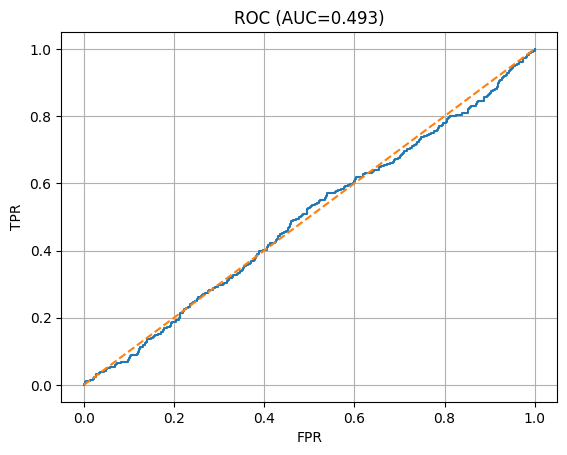

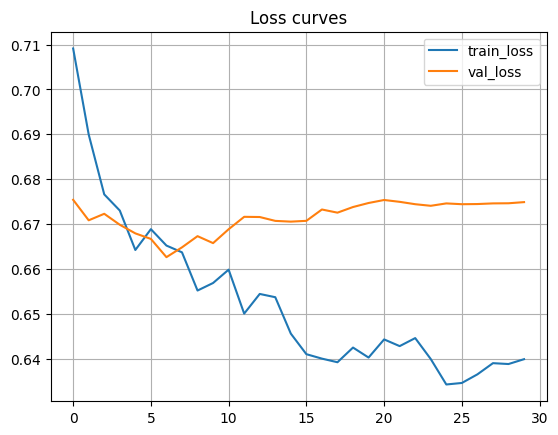

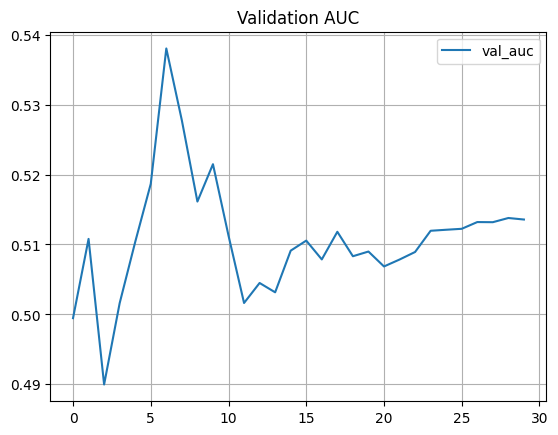

In [14]:
# ЛОГИЧЕСКИЙ БЛОК: evaluate on test + plots
# ИСПОЛНЕНИЕ БЛОКА:

te_loss, te_acc, te_auc, y_true, y_prob = eval_loader(test_loader)
y_pred = (y_prob >= 0.5).astype(int)
cm = confusion_matrix(y_true, y_pred)

print(f"TEST | loss={te_loss:.4f} | acc={te_acc:.3f} | auc={te_auc:.3f}")
print("Confusion matrix:\n", cm)

# ROC
fpr, tpr, _ = roc_curve(y_true, y_prob)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], linestyle="--")
plt.title(f"ROC (AUC={te_auc:.3f})")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.grid(True)
plt.show()

# Loss curves
plt.figure()
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.title("Loss curves")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(history["val_auc"], label="val_auc")
plt.title("Validation AUC")
plt.legend()
plt.grid(True)
plt.show()


## 7. Baselines (majority + random)

In [15]:
# ЛОГИЧЕСКИЙ БЛОК: baselines
# ИСПОЛНЕНИЕ БЛОКА:

# majority baseline на train
y_train_lbl = y[sample_t[idx_train]]
major = int((y_train_lbl.mean() >= 0.5))
print("Majority class:", major, "train mean:", y_train_lbl.mean())

y_major = np.full_like(y_true, major)
acc_major = accuracy_score(y_true, y_major)
try:
    auc_major = roc_auc_score(y_true, y_major.astype(float))
except ValueError:
    auc_major = float("nan")

# random baseline
rng = np.random.default_rng(42)
y_rand_prob = rng.random(len(y_true))
y_rand = (y_rand_prob >= 0.5).astype(int)
acc_rand = accuracy_score(y_true, y_rand)
auc_rand = roc_auc_score(y_true, y_rand_prob)

print(f"MAJORITY | acc={acc_major:.3f} | auc={auc_major}")
print(f"RANDOM   | acc={acc_rand:.3f} | auc={auc_rand:.3f}")


Majority class: 1 train mean: 0.5201928872814949
MAJORITY | acc=0.481 | auc=0.5
RANDOM   | acc=0.482 | auc=0.475
